# Sentiment classification. IMDb dataset.

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import pandas as pd

TensorFlow 2.x selected.


In [2]:
print(tf.__version__)

2.1.0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/capstone2/sentiment_analysis/movie_data.csv', encoding='utf-8')
df.head(3)

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0


In [5]:
df.shape

(50000, 2)

# Clean dataset.

**Removing HTML markup and all non-word characters.**

In [0]:
import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emotions = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           text)
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emotions).replace('-', ''))
    return text

In [0]:
df['review'] = df['review'].apply(preprocessor)

In [8]:
df.head(10)

,review,sentiment
0,in 1974 the teenager martha moxley maggie grac...,1
1,ok so i really like kris kristofferson and his...,0
2,spoiler do not read this if you think about w...,0
3,hi for all the people who have seen this wonde...,1
4,i recently bought the dvd forgetting just how ...,0
5,leave it to braik to put on a good show finall...,1
6,nathan detroit frank sinatra is the manager of...,1
7,to understand crash course in the right contex...,1
8,i ve been impressed with chavez s stance again...,1
9,this movie is directed by renny harlin the fin...,1


**Processing into tokens, stemming and removing stop words.**

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')

porter = PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

def stem_and_remove_stop_words(text, stemming = True):
    stop = stopwords.words('english')
    seperator = ' '
    if stemming == True:
        text = seperator.join([w for w in tokenizer_porter(text) if w not in stop])
    else:
        text = seperator.join([w for w in word_tokenize(text) if w not in stop])
    return text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [11]:
df.loc[0, 'review'][:110]

'in 1974 the teenager martha moxley maggie grace moves to the high class area of belle haven greenwich connecti'

In [12]:
stem_and_remove_stop_words(df.loc[0, 'review'][:110], stemming = True)

'1974 teenag martha moxley maggi grace move high class area bell greenwich connecti'

In [0]:
df['review'] = df['review'].apply(stem_and_remove_stop_words)

In [14]:
df.head(10)

,review,sentiment
0,1974 teenag martha moxley maggi grace move hig...,1
1,ok realli like kri kristofferson hi usual easi...,0
2,spoiler read thi think watch movi although wou...,0
3,hi peopl seen thi wonder movi im sure thet wou...,1
4,recent bought dvd forget much hate movi versio...,0
5,leav braik put good show final zorak live live...,1
6,nathan detroit frank sinatra manag new york lo...,1
7,understand crash cours right context must unde...,1
8,impress chavez stanc globalis sometim saw film...,1
9,thi movi direct renni harlin finnish miracl st...,1


# Creating input list for Word2Vec

In [0]:
reviews = df['review'].values.tolist()
reviews_list = list()

for review in reviews:
    tokens = word_tokenize(review)
    reviews_list.append(tokens)

In [16]:
len(reviews_list)

50000

In [17]:
reviews_list[9][:6]

['thi', 'movi', 'direct', 'renni', 'harlin', 'finnish']

# Word2Vec model

In [0]:
import gensim

In [0]:
w2v_embedding_dim = 100
w2v_window = 5
# train word2vec model
w2v_model = gensim.models.word2vec.Word2Vec(sentences = reviews_list,
                                   window = w2v_window,
                                   min_count = 1,
                                   workers=-1)

In [20]:
# vocabulary size
w2v_vocabulary = list(w2v_model.wv.vocab)
print('Vocabulary size is: %d' %len(w2v_vocabulary))

Vocabulary size is: 73633


In [21]:
w2v_model.wv.most_similar(positive='good')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('jōb', 0.41523197293281555),
 ('jandal', 0.399780809879303),
 ('unfortuneatley', 0.3847445845603943),
 ('majin', 0.3771223723888397),
 ('206', 0.3756157159805298),
 ('partridg', 0.37479084730148315),
 ('zombifi', 0.37468773126602173),
 ('inf', 0.37108534574508667),
 ('marijauna', 0.37054434418678284),
 ('tessari', 0.36657392978668213)]

In [22]:
w2v_model.wv.doesnt_match('woman king queen movie'.split())

/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


'woman'

# Create a dataset.

In [0]:
target = df.pop('sentiment')

ds_raw = tf.data.Dataset.from_tensor_slices(
    (df.values, target.values))

In [24]:
# Inspect:
for entry in ds_raw.take(3):
    tf.print(entry[0].numpy()[0][:50], entry[1])

b'1974 teenag martha moxley maggi grace move high cl' 1
b'ok realli like kri kristofferson hi usual easi go ' 0
b'spoiler read thi think watch movi although would w' 0


# Train / validation / test split. 

In [0]:
tf.random.set_seed(1)

ds_raw = ds_raw.shuffle(
    50000, reshuffle_each_iteration=False)

ds_raw_test = ds_raw.take(25000)
ds_raw_train_valid = ds_raw.skip(25000)
ds_raw_train = ds_raw_train_valid.take(20000)
ds_raw_valid = ds_raw_train_valid.skip(20000)

# Find unique tokens.

In [26]:
from collections import Counter
import tensorflow_datasets as tfds

tokenizer = tfds.features.text.Tokenizer()
token_counts = Counter()

for example in ds_raw_train:
    tokens = tokenizer.tokenize(example[0].numpy()[0])
    token_counts.update(tokens)
    
print('Vocab-size:', len(token_counts))

Vocab-size: 48694


# Encoding each unique token into integers.

In [0]:
encoder = tfds.features.text.TokenTextEncoder(token_counts)

In [28]:
example_str = 'read watch although'
encoder.encode(example_str)

[453, 324, 571]

# Define the function for transformation.

In [0]:
def encode(text_tensor, label):
    text = text_tensor.numpy()[0]
    encoded_text = encoder.encode(text)
    return encoded_text, label

# Wrap the encode function to a TensorFlow operator
def encode_map_fn(text, label):
    return tf.py_function(encode, inp=[text, label], 
                          Tout=(tf.int64, tf.int64))

In [30]:
ds_train = ds_raw_train.map(encode_map_fn)
ds_valid = ds_raw_valid.map(encode_map_fn)
ds_test = ds_raw_test.map(encode_map_fn)

tf.random.set_seed(1)
for example in ds_train.shuffle(1000).take(5):
    print('Sequence length:', example[0].shape)
    
example

Sequence length: (13,)
Sequence length: (93,)
Sequence length: (121,)
Sequence length: (306,)
Sequence length: (64,)


(<tf.Tensor: shape=(64,), dtype=int64, numpy=
 array([  980,   579,   444,     3,   361,   114,     2,     3,   518,
          202,   553,  2818,    43,  6616,   201,   271,   250, 10849,
          136,  1226,   377,   104,  2858,  1777,  2607,  1791,  2421,
          800,   424,  5181,  1943,    53,   488,   396,   179,   356,
          728,   431,  3673,    26,     9,   143,   486,   188,  1051,
        10850,   567,     2,   173,   173,   639,   505,   190, 10851,
         7514,   441,   315,   639,   147,   470,  1314,  6102, 10275,
           83])>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)

# Batching the dataset.

In [0]:
train_data = ds_train.padded_batch(
    32, padded_shapes=([-1],[]))

valid_data = ds_valid.padded_batch(
    32, padded_shapes=([-1],[]))

test_data = ds_test.padded_batch(
    32, padded_shapes=([-1],[]))

# RNN model.

In [36]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dense

embedding_dim = 100
vocab_size = len(token_counts) + 2

tf.random.set_seed(1)

# build the model
bi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size,
                              output_dim=embedding_dim),
    tf.keras.layers.Dense(100,
                          input_shape=(embedding_dim,)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(100, 
                             return_sequences=True)),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(100,
                             return_sequences=False)),
    tf.keras.layers.Dropout(0.9),
    tf.keras.layers.Dense(2, 
                          activation='softmax')
])

bi_lstm_model.summary()

# compile and train:
bi_lstm_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

history = bi_lstm_model.fit(train_data, 
                            validation_data=valid_data, 
                            epochs=6)

# evaluate on the test data:
test_results= bi_lstm_model.evaluate(test_data)
print('Test Acc.: {:.2f}%'.format(test_results[1]*100))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         4869600   
_________________________________________________________________
dense_4 (Dense)              (None, None, 100)         10100     
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 200)         160800    
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 200)               240800    
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)              

In [0]:
import matplotlib.pyplot as plt
def plot_train_valid(model_history):
    hist = model_history.history
    x_arr = np.arange(len(hist['loss'])) + 1

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
    ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)

    return plt.show()

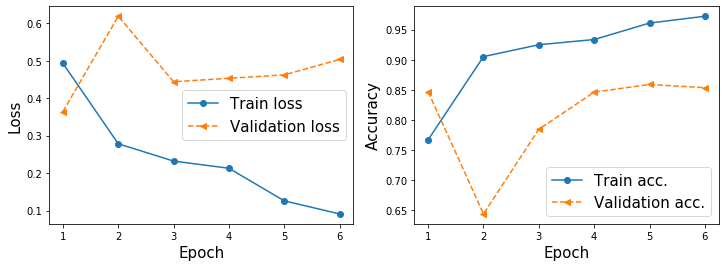

In [38]:
plot_train_valid(history)